# Data Exploration

In [48]:
import numpy as np
import gzip
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.colors import Normalize

### Counter Connectivity and Chip Layout

In [49]:
path = '../../data/chips/NCSU-DigIC-GraphData-2023-07-25/'
results = '../../results/chips/'

with gzip.open(path + 'cells.json.gz', 'rb') as f:
    cells = json.loads(f.read().decode('utf-8'))

conn = np.load(path + 'counter/1/counter_connectivity.npz')
coo = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])

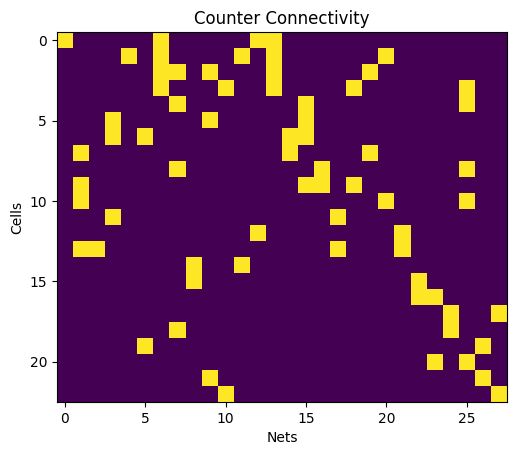

In [50]:
coo_clipped = np.clip(coo.toarray(), 0, 1)
plt.imshow(coo_clipped)
plt.title('Counter Connectivity')
plt.xlabel('Nets')
plt.ylabel('Cells')
plt.savefig(results + 'counter_connectivity.png')
plt.show()

In [51]:
with gzip.open(path + 'counter/1/counter.json.gz', 'rb') as f:
    design = json.loads(f.read().decode('utf-8'))

nets = pd.DataFrame(design['nets'])
instances = pd.DataFrame(design['instances'])
cell_types = pd.DataFrame(cells)

locs = pd.merge(instances, cell_types, left_on='cell', right_on='id')
locs = locs[['xloc', 'yloc', 'orient', 'width', 'height', 'name_x', 'name_y']]

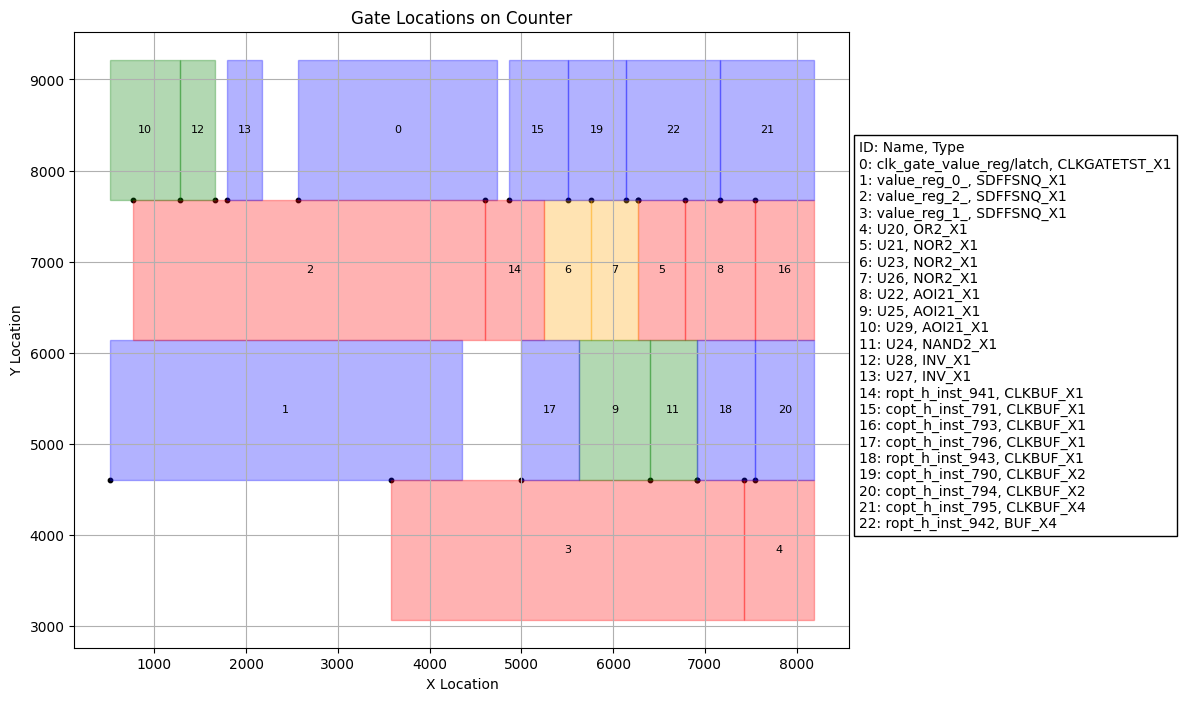

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size
ax.scatter(locs['xloc'], locs['yloc'], color='black', s=10)

# Create a list to collect legend entries
legend_entries = ['ID: Name, Type']
maxw = 0
maxh = 0

for i, (xloc, yloc, orient, width, height, name, ctype) in locs.iterrows():
    color = 'blue' if orient == 0 else 'orange' if orient == 2 else 'green' if orient == 4 else 'red'  # Color by orientation

    # Determine rectangle's starting point based on orientation
    rect_x, rect_y = xloc, yloc
    if orient == 2:
        rect_x -= width
        rect_y -= height
    elif orient == 4:
        rect_x -= width
    elif orient == 6:
        rect_y -= height

    # Add rectangle with a slightly transparent fill color
    rect = Rectangle((rect_x, rect_y), width, height, fill=True, alpha=0.3, edgecolor=color, facecolor=color)
    ax.add_patch(rect)

    maxw = max(maxw, rect_x + width)
    maxh = max(maxh, rect_y + height)

    # Calculate center of the rectangle for text placement
    center_x = rect_x + width / 2
    center_y = rect_y + height / 2

    # Label each gate at the center of the rectangle
    ax.text(center_x, center_y, str(i), color='black', ha='center', va='center', fontsize=8)
    
    # Add entry to legend list
    legend_entries.append(f"{i}: {name}, {ctype}")

# Set plot details
ax.set_xlabel("X Location")
ax.set_ylabel("Y Location")
plt.title("Gate Locations on Counter")
plt.grid(True)
plt.savefig(results + 'counter_gates.png')

# Add custom legend text box on the side
legend_text = "\n".join(legend_entries)
plt.gcf().text(0.91, 0.5, legend_text, va='center', ha='left', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.show()

In [53]:
incidence = coo.toarray()
connections_gates = []

# Map pins to directions
for j in range(len(incidence.T)):
    pin_in = []
    pin_out = []
    for i, pin in enumerate(incidence.T[j]):
        if pin > 0:
            cell_id = instances.iloc[i]['cell']
            if cells[cell_id]['terms'][pin-1]['dir'] == 0:
                pin_in.append(i)
            else:
                pin_out.append(i)

    for x in pin_out:
        for y in pin_in:
            connections_gates.append((x, y, j))

In [54]:
# Map cells to their widths and heights
x = []
y = []
dx = []
dy = []
net_id = []
s = []
e = []
for start, end, k in connections_gates:
    xloc = locs.iloc[start]['xloc']
    yloc = locs.iloc[start]['yloc']
    width = locs.iloc[start]['width']
    height = locs.iloc[start]['height']
    orient = locs.iloc[start]['orient']
    xloc2 = locs.iloc[end]['xloc']
    yloc2 = locs.iloc[end]['yloc']
    width2 = locs.iloc[end]['width']
    height2 = locs.iloc[end]['height']
    orient2 = locs.iloc[end]['orient']
    if orient == 2:
        xloc -= width
        yloc -= height
    elif orient == 4:
        xloc -= width
    elif orient == 6:
        yloc -= height
    if orient2 == 2:
        xloc2 -= width2
        yloc2 -= height2
    elif orient2 == 4:
        xloc2 -= width2
    elif orient2 == 6:
        yloc2 -= height2
    center_x = xloc + width / 2
    center_y = yloc + height / 2
    center_x2 = xloc2 + width2 / 2
    center_y2 = yloc2 + height2 / 2
    x.append(center_x)
    y.append(center_y)
    dx.append(center_x2 - center_x)
    dy.append(center_y2 - center_y)
    net_id.append(k)
    s.append(start)
    e.append(end)

arrows = pd.DataFrame({'x': x, 'y': y, 'dx': dx, 'dy': dy, 'net': net_id, 's': s, 'e': e})

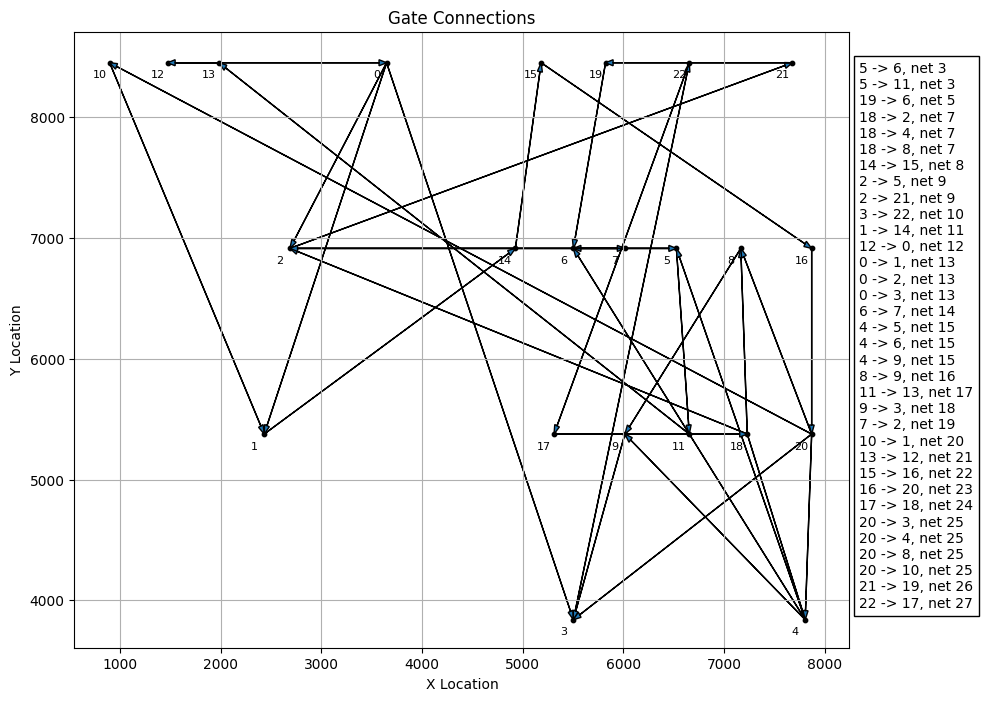

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size
# ax.scatter(locs['xloc'], locs['yloc'], color='black', s=10)

# Create a list to collect legend entries
legend_entries = []

for i, (xloc, yloc, orient, width, height, name, ctype) in locs.iterrows():
    color = 'blue' if orient == 0 else 'orange' if orient == 2 else 'green' if orient == 4 else 'red'  # Color by orientation

    # Determine rectangle's starting point based on orientation
    rect_x, rect_y = xloc, yloc
    if orient == 2:
        rect_x -= width
        rect_y -= height
    elif orient == 4:
        rect_x -= width
    elif orient == 6:
        rect_y -= height

    # Add rectangle with a slightly transparent fill color
    # rect = Rectangle((rect_x, rect_y), width, height, fill=True, alpha=0.3, edgecolor=color, facecolor=color)
    # ax.add_patch(rect)

    # Calculate center of the rectangle for text placement
    center_x = rect_x + width / 2
    center_y = rect_y + height / 2

    # Label each gate at the center of the rectangle
    ax.scatter([center_x], [center_y], color='black', s=10)
    ax.text(center_x-100, center_y-100, str(i), color='black', ha='center', va='center', fontsize=8)
    
    # Add entry to legend list
    

for i, (x, y, dx, dy, n, s, e) in arrows.iterrows():
    plt.arrow(x, y, dx, dy, head_width = 50, length_includes_head=True)
    legend_entries.append(f"{int(s)} -> {int(e)}, net {int(n)}")

# Set plot details
ax.set_xlabel("X Location")
ax.set_ylabel("Y Location")
plt.title("Gate Connections")
plt.grid(True)
plt.savefig(results + 'counter_nets.png')

# Add custom legend text box on the side
legend_text = "\n".join(legend_entries)
plt.gcf().text(0.91, 0.5, legend_text, va='center', ha='left', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

### Xbar layout

In [56]:
conn = np.load(path + 'xbar/1/xbar_connectivity.npz')
coo = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])

with gzip.open(path + 'xbar/1/xbar.json.gz', 'rb') as f:
    design = json.loads(f.read().decode('utf-8'))

nets = pd.DataFrame(design['nets'])
instances = pd.DataFrame(design['instances'])
cell_types = pd.DataFrame(cells)

locs = pd.merge(instances, cell_types, left_on='cell', right_on='id')
locs = locs[['xloc', 'yloc', 'orient', 'width', 'height', 'name_x', 'name_y']]

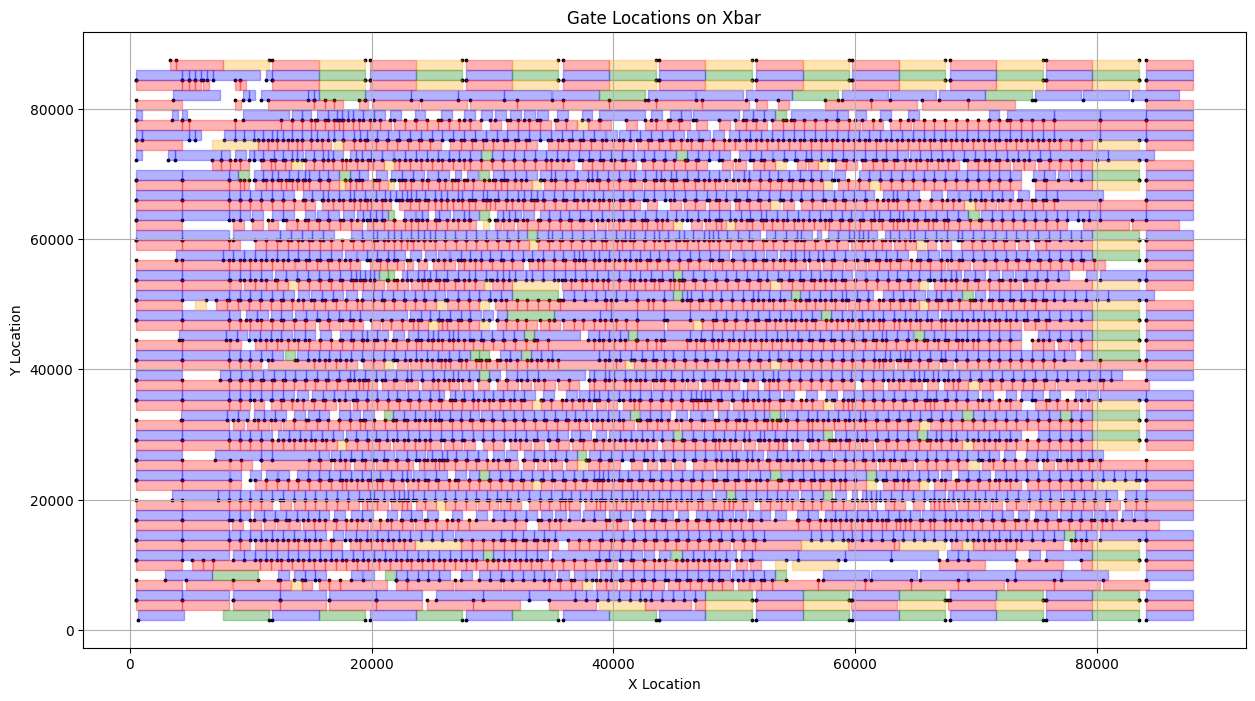

In [57]:
fig, ax = plt.subplots(figsize=(15, 8))  # Increase figure size
ax.scatter(locs['xloc'], locs['yloc'], color='black', s=3)

# Create a list to collect legend entries
# legend_entries = []
maxw = 0
maxh = 0

for i, (xloc, yloc, orient, width, height, name, ctype) in locs.iterrows():
    color = 'blue' if orient == 0 else 'orange' if orient == 2 else 'green' if orient == 4 else 'red'  # Color by orientation

    # Determine rectangle's starting point based on orientation
    rect_x, rect_y = xloc, yloc
    if orient == 2:
        rect_x -= width
        rect_y -= height
    elif orient == 4:
        rect_x -= width
    elif orient == 6:
        rect_y -= height

    # Add rectangle with a slightly transparent fill color
    rect = Rectangle((rect_x, rect_y), width, height, fill=True, alpha=0.3, edgecolor=color, facecolor=color)
    ax.add_patch(rect)

    maxw = max(maxw, rect_x + width)
    maxh = max(maxh, rect_y + height)

    # Calculate center of the rectangle for text placement
    # center_x = rect_x + width / 2
    # center_y = rect_y + height / 2

    # Label each gate at the center of the rectangle
    # ax.text(center_x, center_y, str(i), color='black', ha='center', va='center', fontsize=8)
    
    # Add entry to legend list
    # legend_entries.append(f"{i}: {name}, {ctype}")

# Set plot details
ax.set_xlabel("X Location")
ax.set_ylabel("Y Location")
plt.title("Gate Locations on Xbar")
plt.grid(True)
plt.savefig(results + 'xbar_gates')

plt.show()

### Congestion

In [58]:
data = np.load(path+'/xbar/1/xbar_congestion.npz')

def getGRCIndex(x,y,xbl,ybl):
    j=0
    for b in xbl[1:]:
        if x<b:
            break
        j+=1
    i=0
    for b in ybl[1:]:
        if y<b:
            break
        i+=1
    return i,j

lyr = list(data['layerList']).index('M1')
ybl = data['yBoundaryList']
xbl = data['xBoundaryList']

demand = np.zeros_like(data['demand'][lyr])
for i, l in enumerate(data['layerList']):
    demand += data['demand'][i]
capacity = np.zeros_like(data['capacity'][lyr])
for i, l in enumerate(data['layerList']):
    capacity += data['capacity'][i]

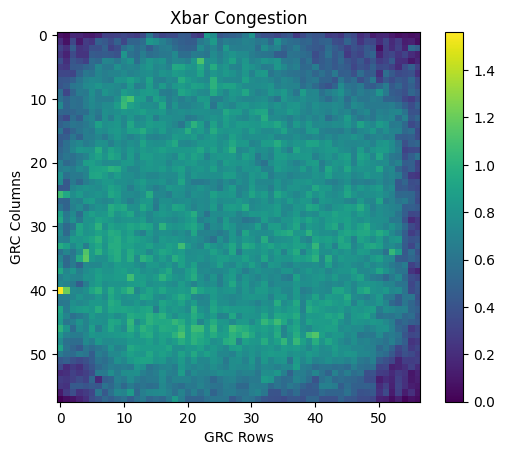

In [59]:
plt.imshow(demand / capacity)
plt.colorbar()
plt.title('Xbar Congestion')
plt.xlabel('GRC Rows')
plt.ylabel('GRC Columns')
plt.savefig(results + 'xbar_congestion.png')
plt.show()

### Xbar Degree Distributions

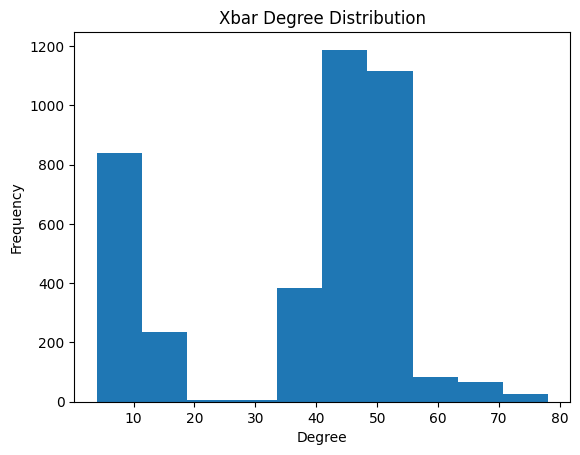

In [62]:
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)
G = nx.from_numpy_array(A)
plt.hist(dict(G.degree()).values())
plt.title('Xbar Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig(results + 'xbar_degrees.png')
plt.show()

### Congestion

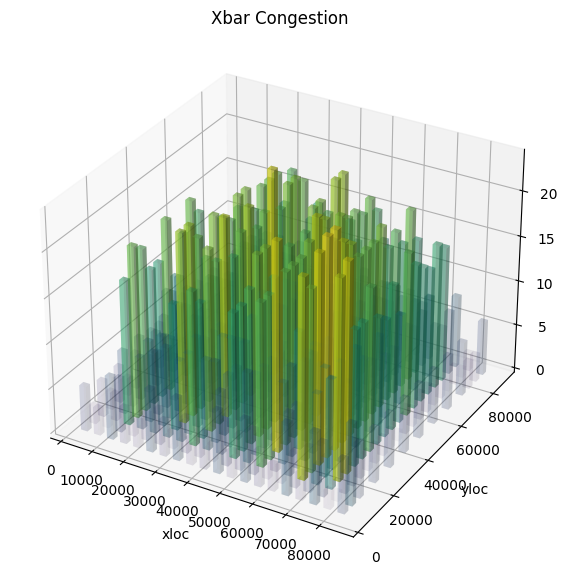

In [63]:
# Get positions
x = instances['xloc']
y = instances['yloc']
bins = 20

hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
xpos = xpos.flatten() / 2
ypos = ypos.flatten() / 2
zpos = np.zeros_like(xpos)

dz = hist.flatten()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
dx = dy = (xedges[1] - xedges[0]) / 2 

norm = Normalize(vmin=min(dz), vmax=max(dz))
colors = cm.viridis(norm(dz))

alphas = norm(dz)/2 # Scales between 0 and 1 based on height
colors[:, -1] = alphas  # Set the alpha channel to the scaled values

# Plot bars with variable color and transparency
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

ax.set_xlabel('xloc')
ax.set_ylabel('yloc')
ax.set_zlabel('Frequency')

plt.title('Xbar Congestion')
plt.savefig(results + 'xbar_3d.png')
plt.show()